In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.metrics import mean_squared_error
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')
url ='/content/drive/MyDrive/Datasets/Khabarovsk_weather_15102020_15102012.csv'

Mounted at /content/drive


# Выполнить загрузку

In [3]:
df = pd.read_csv(url, sep=';', encoding='ISO-8859-1')

In [4]:
df.head()

,LocalTime,T,P0,P,U,DD
0,15.10.2020 23:30,4.0,753.6,760.5,48.0,Âåòåð
1,15.10.2020 23:00,4.0,753.6,760.5,48.0,Âåòåð
2,15.10.2020 22:30,5.0,753.6,760.5,42.0,Âåòåð
3,15.10.2020 22:00,5.0,753.6,760.5,42.0,Âåòåð
4,15.10.2020 21:30,5.0,753.6,760.5,45.0,Âåòåð


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119674 entries, 0 to 119673
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  119674 non-null  object 
 1   T          119665 non-null  float64
 2   P0         119664 non-null  float64
 3   P          119667 non-null  float64
 4   U          119665 non-null  float64
 5   DD         119662 non-null  object 
dtypes: float64(4), object(2)
memory usage: 5.5+ MB


# Выполнить предварительную обработку данных

In [6]:
df=df[['LocalTime','T']]

In [7]:
df.isna().sum()

LocalTime    0
T            9
dtype: int64

In [8]:
df = df.dropna()

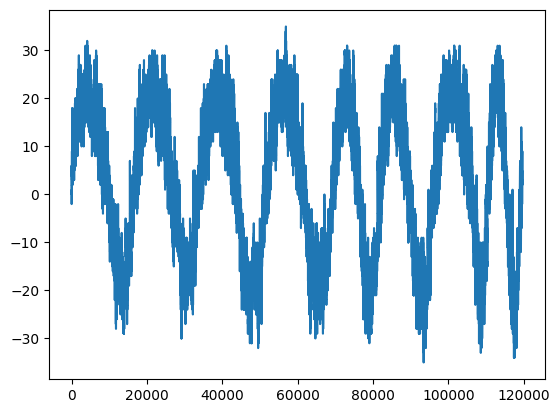

In [9]:
plt.plot(range(1,len(df['T'].values)+1),df['T'].values)

In [10]:
min_max_scaler = MinMaxScaler()
data = df['T'].values
data = min_max_scaler.fit_transform(data.reshape(-1, 1))

In [11]:
print(data.shape)
data= data.flatten()
print(data.shape)

(119665, 1)
(119665,)


# Разделить каждую выборку на обучающую, тестовую и валидационную.

In [12]:
window = 14

In [13]:
n_samples=data.shape[0]-window
n_train_samples=round(0.7*n_samples)
n_val_samples=round(0.15*n_samples)
n_test_samples=n_samples-n_train_samples-n_val_samples
print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  83756 Validation =  17948 Test =  17947


In [14]:
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

In [15]:
for i in range(n_train_samples):
  for j in range(window):
    X_train[i,j]=data[i+j]
  y_train[i]=data[i+window]

for i in range(n_val_samples):
  for j in range(window):
    X_val[i,j]=data[n_train_samples+i+j]
  y_val[i]=data[n_train_samples+i+window]

for i in range(n_test_samples):
  for j in range(window):
    X_test[i,j]=data[n_train_samples+n_val_samples+i+j]
  y_test[i]=data[n_train_samples+n_val_samples+i+window]

# Произвести обучение набора нейросетевых архитектур

## Регрессор встречного распространения

In [51]:
ff_model=Sequential()
ff_model.add(Dense(50,activation='relu',input_dim=window))
ff_model.add(Dropout(0.2))
ff_model.add(Dense(20,activation='relu'))
ff_model.add(Dropout(0.2))
ff_model.add(Dense(1))


In [52]:
ff_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                750       
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,791
Trainable params: 1,791
Non-trainable params: 0
_________________________________________________________________


In [53]:
ff_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [54]:
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/StudyData/Models/ff-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)

callbacks_list=[early_stop,checkpoint]

In [55]:
ff_model_history = ff_model.fit(X_train,y_train,batch_size=25,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
3325/3351 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0581
Epoch 1: val_mae improved from inf to 0.03104, saving model to /content/gdrive/My Drive/StudyData/Models/ff-temperature-01-0.031.hdf5
3351/3351 [==============================] - 6s 2ms/step - loss: 0.0076 - mae: 0.0580 - val_loss: 0.0014 - val_mae: 0.0310
Epoch 2/40
3337/3351 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0382
Epoch 2: val_mae improved from 0.03104 to 0.01803, saving model to /content/gdrive/My Drive/StudyData/Models/ff-temperature-02-0.018.hdf5
3351/3351 [==============================] - 6s 2ms/step - loss: 0.0025 - mae: 0.0382 - val_loss: 5.2395e-04 - val_mae: 0.0180
Epoch 3/40
3327/3351 [============================>.] - ETA: 0s - loss: 0.0023 - mae: 0.0363
Epoch 3: val_mae did not improve from 0.01803
3351/3351 [==============================] - 5s 2ms/step - loss: 0.0023 - mae: 0.0363 - val_loss: 6.7117e-04 - val_mae: 0.0196
Epoch 4/40
3345/3351 [====

In [56]:
ff_model.load_weights('/content/gdrive/My Drive/StudyData/Models/ff-temperature-02-0.018.hdf5')

In [57]:
loss_function = ff_model_history.history['loss']
val_loss_function = ff_model_history.history['val_loss']
epochs=range(1,len(loss_function)+1)

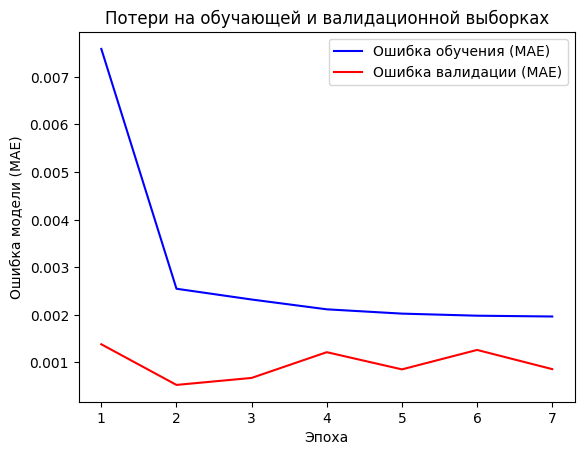

In [58]:
plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [59]:
y_pred = ff_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(y_test_inv,y_pred_inv)
mae = mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv)
r2 = r2_score(y_test_inv,y_pred_inv)

print('MSE = ',round(mse,3))
print('MAE = ',round(mae,3),' K degrees')
print('R2-score = ',round(r2,3))

561/561 [==============================] - 1s 866us/step
MSE =  3.432
MAE =  1.432  K degrees
R2-score =  0.986


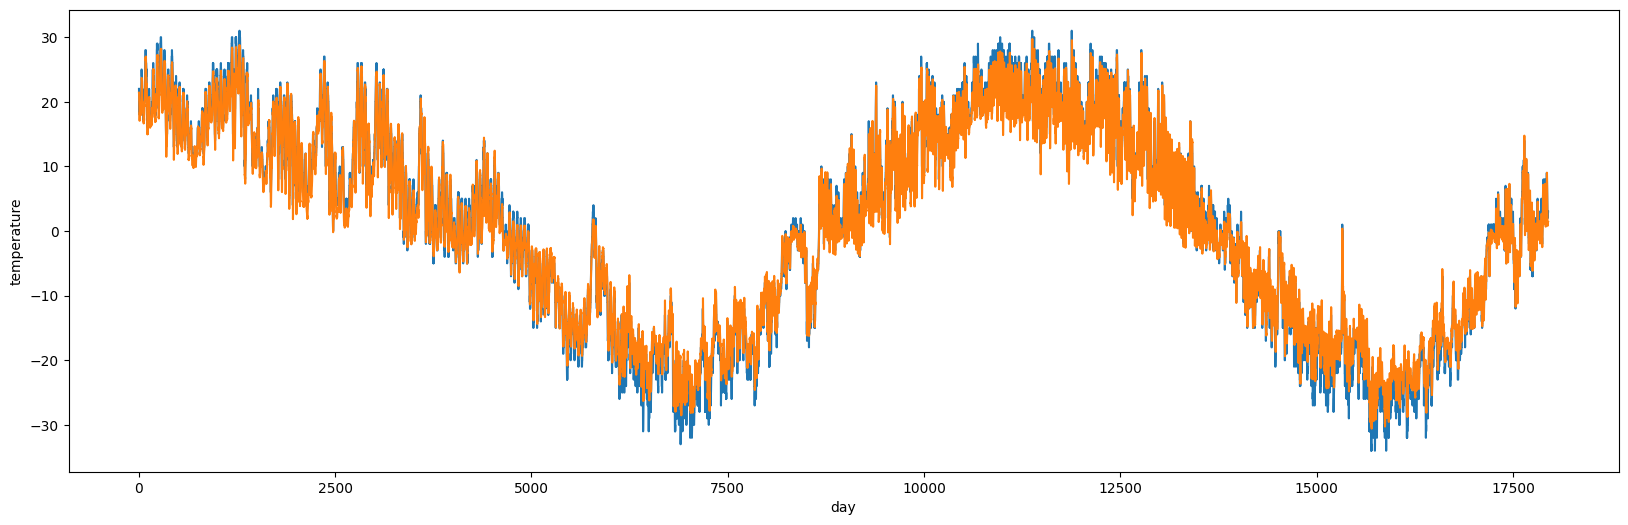

In [60]:
plt.figure(figsize=(20,6))
plt.ylabel('temperature')
plt.xlabel('day')
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)
plt.show()

In [61]:
# предсказание температуры на следующий день
last_week_temp = data[-window:]
last_week_temp = last_week_temp.reshape(1, -1)
next_day_temp_scaled = ff_model.predict(last_week_temp)
next_day_temp = min_max_scaler.inverse_transform(next_day_temp_scaled)
print('Predicted temperature for the next day:', next_day_temp[0][0])

1/1 [==============================] - 0s 46ms/step
Predicted temperature for the next day: 1.5698749


In [62]:
# предсказание средней температуры на следующую неделю
last_week_temp = data[-7*window:]
last_week_temp = last_week_temp.reshape(-1, window)
next_week_temp_scaled = ff_model.predict(last_week_temp)
next_week_temp = min_max_scaler.inverse_transform(next_week_temp_scaled)
mean_next_week_temp = np.mean(next_week_temp)
print('Predicted average temperature for the next week:', mean_next_week_temp)

1/1 [==============================] - 0s 17ms/step
Predicted average temperature for the next week: 3.341675


## Регрессор, использующий слой RNN в качестве скрытого слоя 

In [31]:
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(30,activation='relu',input_shape=(window,1)))
simple_rnn_model.add(Dropout(0.2))
simple_rnn_model.add(Dense(1,activation='linear'))

In [32]:
simple_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


In [33]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [34]:
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [35]:
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [36]:
simple_rnn_model_history = simple_rnn_model.fit(X_train,y_train,batch_size=25,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
3331/3351 [============================>.] - ETA: 0s - loss: 0.0138 - mae: 0.0606
Epoch 1: val_mae improved from inf to 0.01444, saving model to /content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-01-0.014.hdf5
3351/3351 [==============================] - 11s 3ms/step - loss: 0.0137 - mae: 0.0604 - val_loss: 3.7172e-04 - val_mae: 0.0144
Epoch 2/40
3337/3351 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0307
Epoch 2: val_mae improved from 0.01444 to 0.01291, saving model to /content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-02-0.013.hdf5
3351/3351 [==============================] - 10s 3ms/step - loss: 0.0017 - mae: 0.0307 - val_loss: 2.9646e-04 - val_mae: 0.0129
Epoch 3/40
3349/3351 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0277
Epoch 3: val_mae improved from 0.01291 to 0.01283, saving model to /content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-03-0.013.hdf5
3351/3351 [====================

In [37]:
simple_rnn_model.load_weights('/content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-11-0.010.hdf5')

In [38]:
loss_function = simple_rnn_model_history.history['loss']
val_loss_function = simple_rnn_model_history.history['val_loss']
epochs=range(1,len(loss_function)+1)

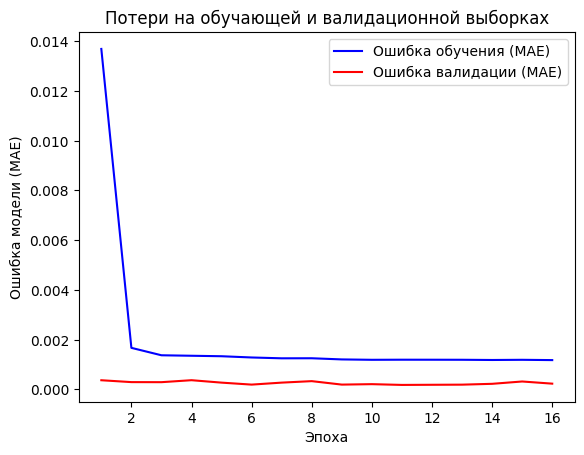

In [39]:
plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [40]:
y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MSE = ',round(mean_squared_error(y_test_inv,y_pred_inv),3))
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

561/561 [==============================] - 1s 1ms/step
MSE =  1.135
MAE =  0.791  K degrees
R2-score =  0.995


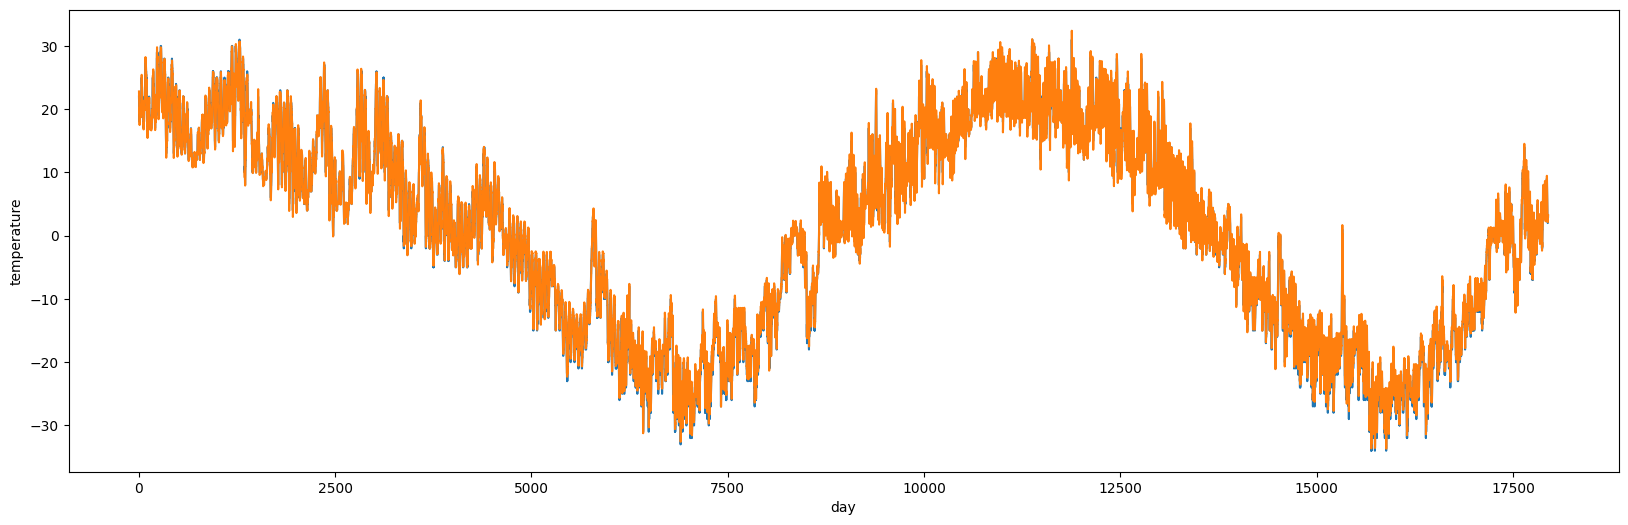

In [41]:
plt.figure(figsize=(20,6))
plt.ylabel('temperature')
plt.xlabel('day')
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)
plt.show()

In [46]:
# предсказание температуры на следующий день
last_window = data[-window:]
last_window = min_max_scaler.transform(last_window.reshape(-1, 1))
last_window = np.reshape(last_window, (1, window, 1))
next_day_pred = simple_rnn_model.predict(last_window)
next_day_pred_inv = min_max_scaler.inverse_transform(next_day_pred)
print('Predicted temperature for the next day:', next_day_pred_inv[0][0])

1/1 [==============================] - 0s 66ms/step
Predicted temperature for the next day: 0.6720406


In [50]:
# предсказание средней температуры на следующую неделю
days_in_week = 7
prev_weeks = 4

num_values = window + days_in_week * prev_weeks

last_values = data[-num_values:]
last_values = min_max_scaler.transform(last_values.reshape(-1, 1))
last_values = np.reshape(last_values, (1, num_values, 1))

next_week_pred = simple_rnn_model.predict(last_values)
next_week_pred_inv = min_max_scaler.inverse_transform(next_week_pred)
mean_next_week_temp = np.mean(next_week_pred_inv)
print('Predicted average temperature for the next week:', mean_next_week_temp)


1/1 [==============================] - 0s 61ms/step
Predicted average temperature for the next week: 0.58506846


## Регрессор, ячейку LSTM в скрытом слое

In [16]:
model = Sequential()
model.add(LSTM(10,input_shape=(window,1)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',loss='mse',metrics='mae')

In [19]:
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/StudyData/Models/temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [20]:
history = model.fit(X_train,y_train,epochs=30,batch_size=32,
                    callbacks=callbacks_list,
                    validation_data=(X_val,y_val))

Epoch 1/30
2616/2618 [============================>.] - ETA: 0s - loss: 0.0105 - mae: 0.0659
Epoch 1: val_mae improved from inf to 0.02351, saving model to /content/gdrive/My Drive/StudyData/Models/temperature-01-0.024.hdf5
2618/2618 [==============================] - 16s 5ms/step - loss: 0.0105 - mae: 0.0659 - val_loss: 9.2502e-04 - val_mae: 0.0235
Epoch 2/30
2614/2618 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0323
Epoch 2: val_mae improved from 0.02351 to 0.01873, saving model to /content/gdrive/My Drive/StudyData/Models/temperature-02-0.019.hdf5
2618/2618 [==============================] - 13s 5ms/step - loss: 0.0019 - mae: 0.0323 - val_loss: 5.8727e-04 - val_mae: 0.0187
Epoch 3/30
2610/2618 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0282
Epoch 3: val_mae improved from 0.01873 to 0.01473, saving model to /content/gdrive/My Drive/StudyData/Models/temperature-03-0.015.hdf5
2618/2618 [==============================] - 16s 6ms/step - loss

In [21]:
model.load_weights('/content/gdrive/My Drive/StudyData/Models/temperature-09-0.010.hdf5')

In [22]:
loss_function = history.history['loss']
val_loss_function = history.history['val_loss']
epochs=range(1,len(loss_function)+1)

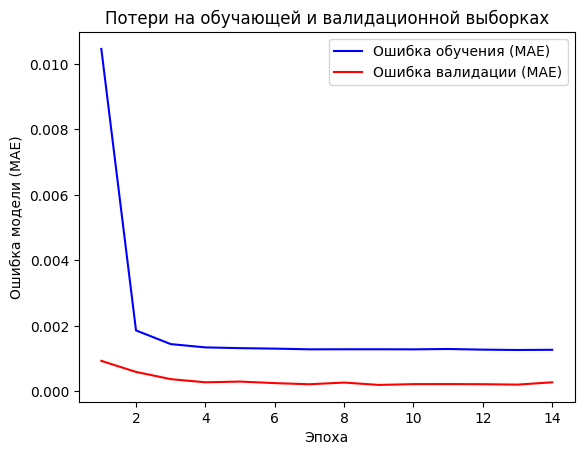

In [23]:
plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MSE = ',round(mean_squared_error(y_test_inv,y_pred_inv),3))
print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))
print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv,
                                                     y_pred=y_pred_inv),3))

561/561 [==============================] - 1s 1ms/step
MSE =  1.165
R2 Score (Test) =  0.995
MAE (Test) =  0.796


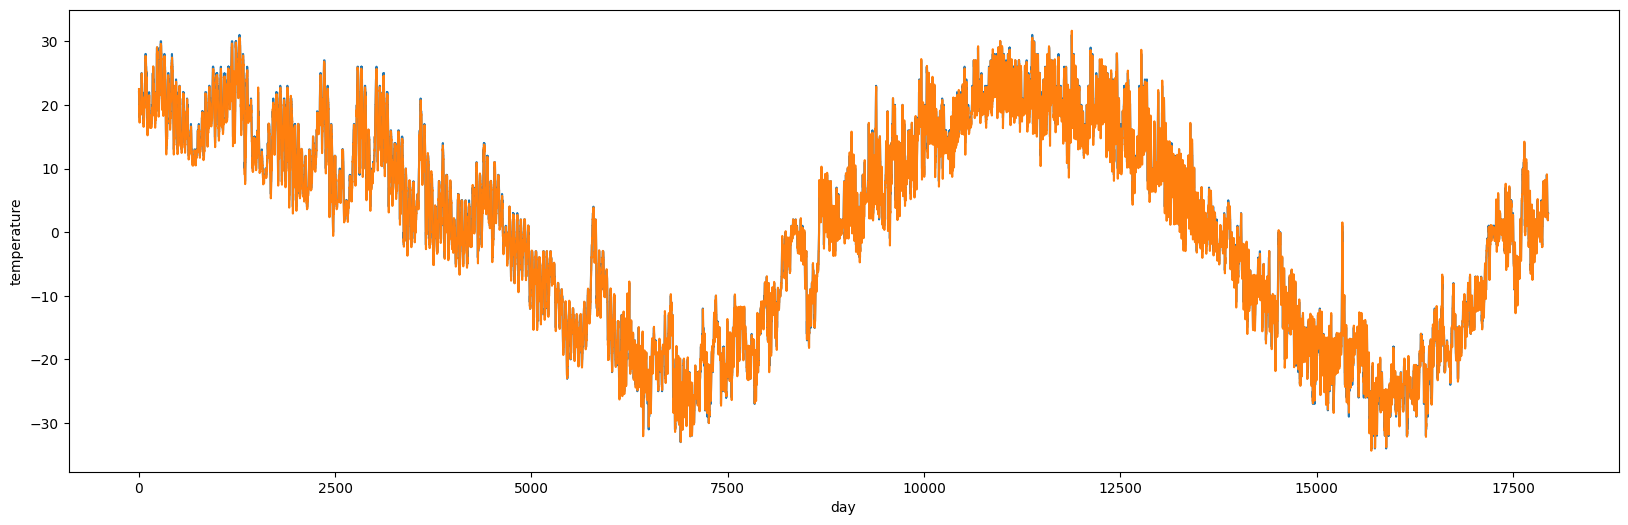

In [25]:
plt.figure(figsize=(20,6))
plt.ylabel('temperature')
plt.xlabel('day')
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)
plt.show()

In [30]:
# предсказание температуры на следующий день
last_week_temp = data[-window:]
last_week_temp = last_week_temp.reshape(1, -1)
next_day_temp_scaled = model.predict(last_week_temp)
next_day_temp = min_max_scaler.inverse_transform(next_day_temp_scaled)
print('Predicted temperature for the next day:', next_day_temp[0][0])

1/1 [==============================] - 0s 17ms/step
Predicted temperature for the next day: 2.837586


In [29]:
# предсказание средней температуры на следующую неделю
last_week_temp = data[-7*window:]
last_week_temp = last_week_temp.reshape(-1, window)
next_week_temp_scaled = model.predict(last_week_temp)
next_week_temp = min_max_scaler.inverse_transform(next_week_temp_scaled)
mean_next_week_temp = np.mean(next_week_temp)
print('Predicted average temperature for the next week:', mean_next_week_temp)

1/1 [==============================] - 0s 50ms/step
Predicted average temperature for the next week: 4.3418016
